# Import Library

In [1]:
# !pip install Levenshtein

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Concatenate, Attention, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from gensim.models import FastText
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from Levenshtein import distance as levenshtein_distance

In [3]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Data Understanding

In [4]:
# '''
# Get The Data - All Language
# '''

# data = drive.CreateFile({'id':'1ACNH6riCVczdndxwhfVL98UOuu_Fjndp'})
# data.GetContentFile('Jawa-Sunda.csv')

In [5]:
df = pd.read_csv('Jawa-Sunda.csv')
df.head()

,language,pegon,latin
0,Jawa,تاريخ,tariḵ
1,Jawa,والى,wali
2,Jawa,سڠا,sṅa
3,Jawa,نࣤرَاڠَاكࣤنْ,něraṅakěn
4,Jawa,بَبَادْاِيْفُونْ,babadipun


In [6]:
'''
Split Train and Testing Data
'''

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (5927, 3)
Shape of testing set: (659, 3)


# Data Preprocessing

In [7]:
def preprocess(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '\t' + str(x).lower() + '\n')
    return df

In [8]:
'''
Convert to Lower Case and Add Start and End Token of the Latin Words
'''

train_df = preprocess(train_df, 'latin')
train_df.head()

,language,pegon,latin
1199,Jawa,ڮَايَا,\tgaya\n
177,Jawa,سࣤدَايَا,\tsědaya\n
5836,Sunda,فَفَارِيْنْ,\tpaparin\n
2202,Sunda,سَبْدَا,\tsabda\n
5019,Sunda,مُفْسِدِيْنَ,\tmupsidin\n


In [9]:
def train_fasttext_model(sentences, window=7, vector_size=300, epochs=150, min_count=0, sg=1):
    model = FastText(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        epochs=epochs,
        min_count=min_count,
        sg=sg
    )
    return model

In [10]:
def create_tokenizer(column_data):
    # Create a tokenizer for character-level tokenization
    tokenizer = Tokenizer(char_level=True)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(column_data)

    return tokenizer

In [11]:
def create_input_sequences(column_data, tokenizer):
    # Get the size of the vocabulary (number of unique characters) plus one for padding
    char_size = len(tokenizer.word_index) + 1

    # Encode the text data into sequences of integers
    encoded = tokenizer.texts_to_sequences(column_data)

    # Find the maximum sequence length
    max_len = max(len(seq) for seq in encoded)

    # Pad the sequences to ensure uniform length
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return char_size, encoded, max_len, padded

In [12]:
# Create Pegon Character Tokenizer
pegon_tokenizer = create_tokenizer(train_df['pegon'])

# Create Latin Character Tokenizer
latin_tokenizer = create_tokenizer(train_df['latin'])

In [13]:
# Create Input Sequences of Pegon Words
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(train_df['pegon'], pegon_tokenizer)

# Create Input Sequences of Latin Words
latin_char_size, latin_encoded, latin_max_len, padded_latin = create_input_sequences(train_df['latin'], latin_tokenizer)

In [14]:
'''
Save Tokenizer
'''

filename = 'pegon_tokenizer.pkl'
pickle.dump(pegon_tokenizer, open(filename, 'wb'))

filename = 'latin_tokenizer.pkl'
pickle.dump(latin_tokenizer, open(filename, 'wb'))

In [15]:
'''
Latin Token Index
'''

latin_index = latin_tokenizer.word_index
latin_df = pd.DataFrame(list(latin_index.items()), columns=['Char', 'Index'])
latin_df.set_index('Char', inplace=True)
latin_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
ě,8
l,9


In [16]:
'''
Pegon Token Index
'''

pegon_index = latin_tokenizer.word_index
pegon_df = pd.DataFrame(list(pegon_index.items()), columns=['Char', 'Index'])
pegon_df.set_index('Char', inplace=True)
pegon_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
ě,8
l,9


In [17]:
'''
Check All of Variables
'''

print("Number of characters in Pegon:", pegon_char_size)
print("Number of characters in Latin:", latin_char_size)

print()

print("Example of Encoded Pegon:", pegon_encoded[0])
print("Example of Encoded Latin:", latin_encoded[0])

print()

print("Max Length of Encoded Pegon Sequences:", pegon_max_len)
print("Max Length of Encoded Latin Sequences", latin_max_len)


print()

print("Example of Encoded Pegon with Padding:", padded_pegon[0])
print("Example of Encoded Latin with Padding:", padded_latin[0])

Number of characters in Pegon: 69
Number of characters in Latin: 57

Example of Encoded Pegon: [24, 1, 3, 8, 1, 3]
Example of Encoded Latin: [2, 22, 1, 24, 1, 3]

Max Length of Encoded Pegon Sequences: 21
Max Length of Encoded Latin Sequences 18

Example of Encoded Pegon with Padding: [24  1  3  8  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Example of Encoded Latin with Padding: [ 2 22  1 24  1  3  0  0  0  0  0  0  0  0  0  0  0  0]


In [18]:
'''
Train fastText model both Latin and Pegon
'''

vector_size = 300

pegon_vectorizer = train_fasttext_model(df['pegon'], vector_size)
latin_vectorizer = train_fasttext_model(df['latin'], vector_size)

In [19]:
def create_embedding_matrix(tokenizer, vectorizer):
    # Initialize embedding matrix
    char_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((char_size, vectorizer.vector_size))

    # Fill embedding matrix
    for char, i in tokenizer.word_index.items():
        embedding_vector = vectorizer.wv[char]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [20]:
'''
Create the Embedding Matrix for both Pegon and Latin
'''

pegon_emb_mat = create_embedding_matrix(pegon_tokenizer, pegon_vectorizer)
latin_emb_mat = create_embedding_matrix(latin_tokenizer, latin_vectorizer)


print("Example of Pegon Embedding Matrix:\n", pegon_emb_mat)
print("Example of Latin Embedding Matrix:\n", latin_emb_mat)

Example of Pegon Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.05531564  0.10364999 -0.01954385 ... -0.05946495  0.06009392
  -0.06837494]
 [-0.0478057   0.12815042 -0.04940021 ... -0.03697941  0.04585915
  -0.10143579]
 ...
 [-0.00912255  0.05131535  0.0106448  ...  0.02752666  0.09946743
   0.05704297]
 [-0.10689782  0.12306388  0.15429129 ... -0.13110557 -0.00354424
  -0.11616887]
 [-0.09781147  0.01946111  0.1394401  ...  0.0807028  -0.03855134
  -0.07374597]]
Example of Latin Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02787714 -0.02407313 -0.00636679 ... -0.01124332 -0.00718194
  -0.01045825]
 [-0.00063902  0.00246553 -0.00065751 ...  0.00165612  0.0028372
  -0.00297938]
 ...
 [ 0.03449237  0.2875469   0.17355858 ...  0.07341801  0.21449219
  -0.081386  ]
 [ 0.1061893   0.07954618 -0.13019836 ... -0.04570915  0.0066632
  -0.20003352]
 [ 0.07242788  0.06649795  0.0985193  ... -0

# Modelling

In [21]:
'''
Split Train and Validation Data
'''

X_train, X_val, y_train, y_val = train_test_split(padded_pegon, padded_latin, test_size=0.1, random_state=42)

print("Shape of Pegon Train:", X_train.shape)
print("Shape of Latin Train:", y_train.shape)
print("Shape of Pegon Validation:", X_val.shape)
print("Shape of Latin Validation:", y_val.shape)

Shape of Pegon Train: (5334, 21)
Shape of Latin Train: (5334, 18)
Shape of Pegon Validation: (593, 21)
Shape of Latin Validation: (593, 18)


In [22]:
def compile_model(model):
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

In [23]:
def create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [24]:
def create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_outputs, forward_h, backward_h = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_outputs, _ = GRU(latent_dim*2, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [25]:
def create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [26]:
def create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, backward_h = encoder_gru(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [27]:
def train_model(model, X_train, X_val, y_train, y_val, epochs=100, batch_size=64, patience=7):
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                        callbacks=[early_stopping])

    training_time_seconds = time.time() - start_time
    training_time_minutes = training_time_seconds / 60.0
    print(f"Training time: {training_time_minutes:.2f} minutes")

    return model, training_time_minutes, history

## Create Model

In [28]:
'''
Create bilstm_att Seq2Seq Model
'''

bilstm_att = create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bilstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 21, 512)              35328     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 21, 1024),           4198400   ['embedding[0][0]']           
 al)                          (None, 512),                                                    

In [29]:
'''
Create bigru_att Seq2Seq Model
'''

bigru_att = create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bigru_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 21, 512)              35328     ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 21, 1024),           3151872   ['embedding_2[0][0]']         
 onal)                        (None, 512),                                                  

In [30]:
'''
Create fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att = create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bilstm_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 21, 300)              20700     ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  [(None, 21, 1024),           3330048   ['embedding_4[0][0]']         
 onal)                        (None, 512),                                                  

In [31]:
'''
Create fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att = create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bigru_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 21, 300)              20700     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  [(None, 21, 1024),           2500608   ['embedding_6[0][0]']         
 onal)                        (None, 512),                                                  

## Training Model

In [32]:
'''
Train bilstm_att Seq2Seq Model
'''

bilstm_att, bilstm_att_training_time, bilstm_att_history = train_model(bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
84/84 [==============================] - 82s 905ms/step - loss: 1.3483 - accuracy: 0.6629 - val_loss: 1.0349 - val_accuracy: 0.7239
Epoch 2/100
84/84 [==============================] - 76s 908ms/step - loss: 0.8089 - accuracy: 0.7833 - val_loss: 0.5125 - val_accuracy: 0.8666
Epoch 3/100
84/84 [==============================] - 76s 908ms/step - loss: 0.2303 - accuracy: 0.9456 - val_loss: 0.1085 - val_accuracy: 0.9744
Epoch 4/100
84/84 [==============================] - 80s 952ms/step - loss: 0.0951 - accuracy: 0.9770 - val_loss: 0.0728 - val_accuracy: 0.9842
Epoch 5/100
84/84 [==============================] - 78s 927ms/step - loss: 0.0461 - accuracy: 0.9888 - val_loss: 0.0371 - val_accuracy: 0.9913
Epoch 6/100
84/84 [==============================] - 77s 915ms/step - loss: 0.0343 - accuracy: 0.9911 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 7/100
84/84 [==============================] - 77s 922ms/step - loss: 0.0300 - accuracy: 0.9920 - val_loss: 0.0284 - val_accuracy:

In [33]:
'''
Train bigru_att Seq2Seq Model
'''

bigru_att, bigru_att_training_time, bigru_att_history = train_model(bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
84/84 [==============================] - 67s 735ms/step - loss: 1.2704 - accuracy: 0.6809 - val_loss: 0.7912 - val_accuracy: 0.7964
Epoch 2/100
84/84 [==============================] - 60s 720ms/step - loss: 0.3098 - accuracy: 0.9251 - val_loss: 0.1261 - val_accuracy: 0.9719
Epoch 3/100
84/84 [==============================] - 63s 746ms/step - loss: 0.0777 - accuracy: 0.9813 - val_loss: 0.1100 - val_accuracy: 0.9750
Epoch 4/100
84/84 [==============================] - 61s 723ms/step - loss: 0.0429 - accuracy: 0.9893 - val_loss: 0.0343 - val_accuracy: 0.9925
Epoch 5/100
84/84 [==============================] - 62s 742ms/step - loss: 0.0284 - accuracy: 0.9924 - val_loss: 0.0276 - val_accuracy: 0.9939
Epoch 6/100
84/84 [==============================] - 63s 745ms/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 0.0315 - val_accuracy: 0.9928
Epoch 7/100
84/84 [==============================] - 62s 740ms/step - loss: 0.0235 - accuracy: 0.9937 - val_loss: 0.0258 - val_accuracy:

In [34]:
'''
Train fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history = train_model(fasttext_bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
84/84 [==============================] - 71s 787ms/step - loss: 1.4010 - accuracy: 0.6488 - val_loss: 1.0789 - val_accuracy: 0.7000
Epoch 2/100
84/84 [==============================] - 66s 790ms/step - loss: 0.8635 - accuracy: 0.7645 - val_loss: 0.5986 - val_accuracy: 0.8397
Epoch 3/100
84/84 [==============================] - 64s 765ms/step - loss: 0.3239 - accuracy: 0.9179 - val_loss: 0.1676 - val_accuracy: 0.9602
Epoch 4/100
84/84 [==============================] - 64s 767ms/step - loss: 0.1059 - accuracy: 0.9752 - val_loss: 0.0742 - val_accuracy: 0.9808
Epoch 5/100
84/84 [==============================] - 66s 784ms/step - loss: 0.0708 - accuracy: 0.9830 - val_loss: 0.0590 - val_accuracy: 0.9862
Epoch 6/100
84/84 [==============================] - 64s 766ms/step - loss: 0.0501 - accuracy: 0.9877 - val_loss: 0.0532 - val_accuracy: 0.9888
Epoch 7/100
84/84 [==============================] - 64s 766ms/step - loss: 0.0344 - accuracy: 0.9911 - val_loss: 0.0305 - val_accuracy:

In [35]:
'''
Train fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history = train_model(fasttext_bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
84/84 [==============================] - 58s 621ms/step - loss: 1.3880 - accuracy: 0.6591 - val_loss: 0.9786 - val_accuracy: 0.7235
Epoch 2/100
84/84 [==============================] - 52s 620ms/step - loss: 0.6007 - accuracy: 0.8455 - val_loss: 0.2985 - val_accuracy: 0.9252
Epoch 3/100
84/84 [==============================] - 52s 623ms/step - loss: 0.1208 - accuracy: 0.9722 - val_loss: 0.0681 - val_accuracy: 0.9856
Epoch 4/100
84/84 [==============================] - 52s 618ms/step - loss: 0.0638 - accuracy: 0.9851 - val_loss: 0.0440 - val_accuracy: 0.9900
Epoch 5/100
84/84 [==============================] - 52s 619ms/step - loss: 0.0353 - accuracy: 0.9909 - val_loss: 0.0342 - val_accuracy: 0.9919
Epoch 6/100
84/84 [==============================] - 53s 629ms/step - loss: 0.0282 - accuracy: 0.9925 - val_loss: 0.0459 - val_accuracy: 0.9895
Epoch 7/100
84/84 [==============================] - 52s 614ms/step - loss: 0.0311 - accuracy: 0.9918 - val_loss: 0.0287 - val_accuracy:

# Model Evaluation

In [36]:
def evaluate_model(model, X_val, y_val):
    evaluation_result = model.evaluate([X_val, y_val[:, :-1]], y_val[:, 1:])
    loss = evaluation_result[0]
    accuracy = evaluation_result[1]

    return loss, accuracy

In [37]:
'''
Evaluate Model
'''

models = {
    'bilstm_att': [bilstm_att, bilstm_att_training_time, bilstm_att_history],
    'bigru_att': [bigru_att, bigru_att_training_time, bigru_att_history],
    'fasttext_bilstm_att': [fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history],
    'fasttext_bigru_att': [fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history]
}

evaluation_results = []

for model_name, values in models.items():
    model = values[0]
    training_time = values[1]
    history = values[2]
    loss, accuracy = evaluate_model(model, X_val, y_val)
    evaluation_results.append({
        'Model': model_name,
        'Loss': loss,
        'Accuracy': accuracy,
        'Epochs' : len(history.history['loss']),
        'Avg Training Time (m)': round(training_time/len(history.history['loss']), 2),
        'Total Training Time (m)': round(training_time, 2)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

19/19 [==============================] - 3s 145ms/step - loss: 0.0168 - accuracy: 0.9956


,Model,Loss,Accuracy,Epochs,Avg Training Time (m),Total Training Time (m)
0,bilstm_att,0.013746,0.995338,26,1.31,34.17
1,bigru_att,0.014563,0.996131,28,1.04,29.08
2,fasttext_bilstm_att,0.015437,0.995635,40,1.08,43.07
3,fasttext_bigru_att,0.016782,0.995635,32,0.86,27.60


In [38]:
def plot_loss_accuracy(model_name, history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', None)
    val_accuracy = history.history.get('val_accuracy', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

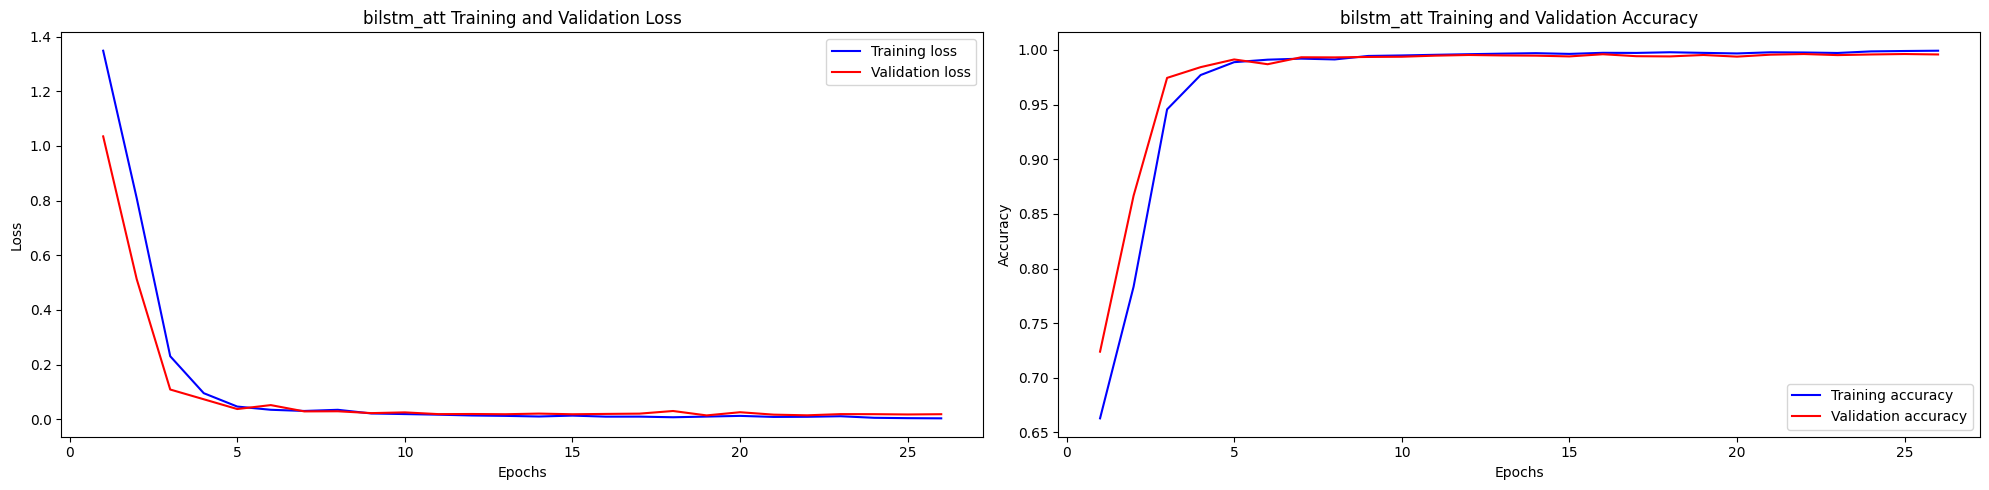

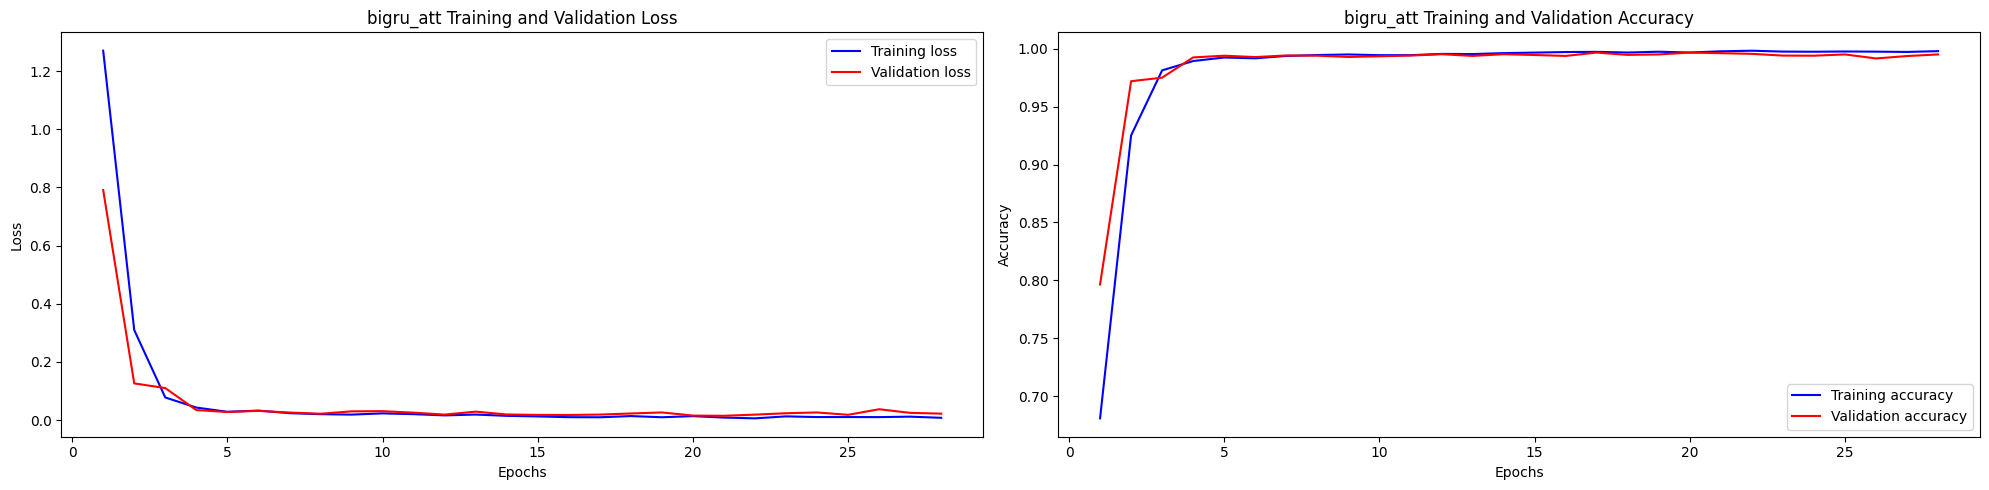

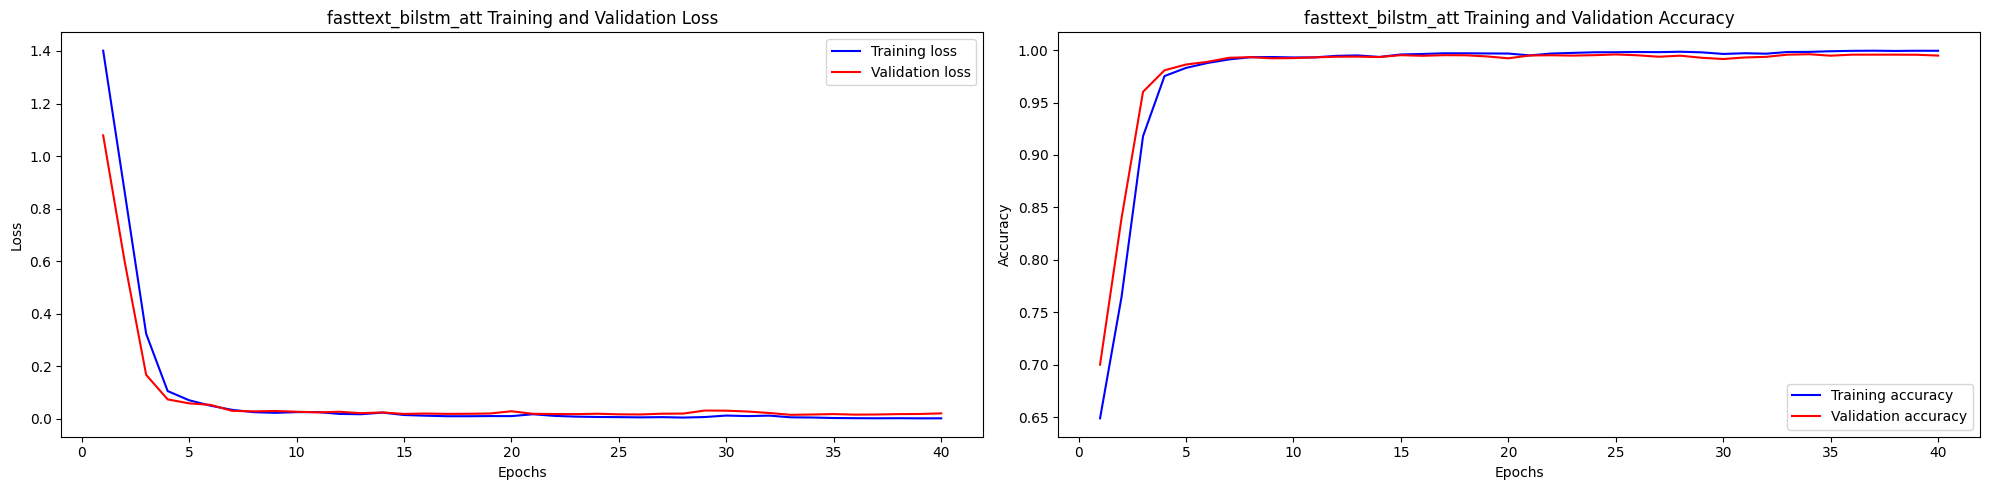

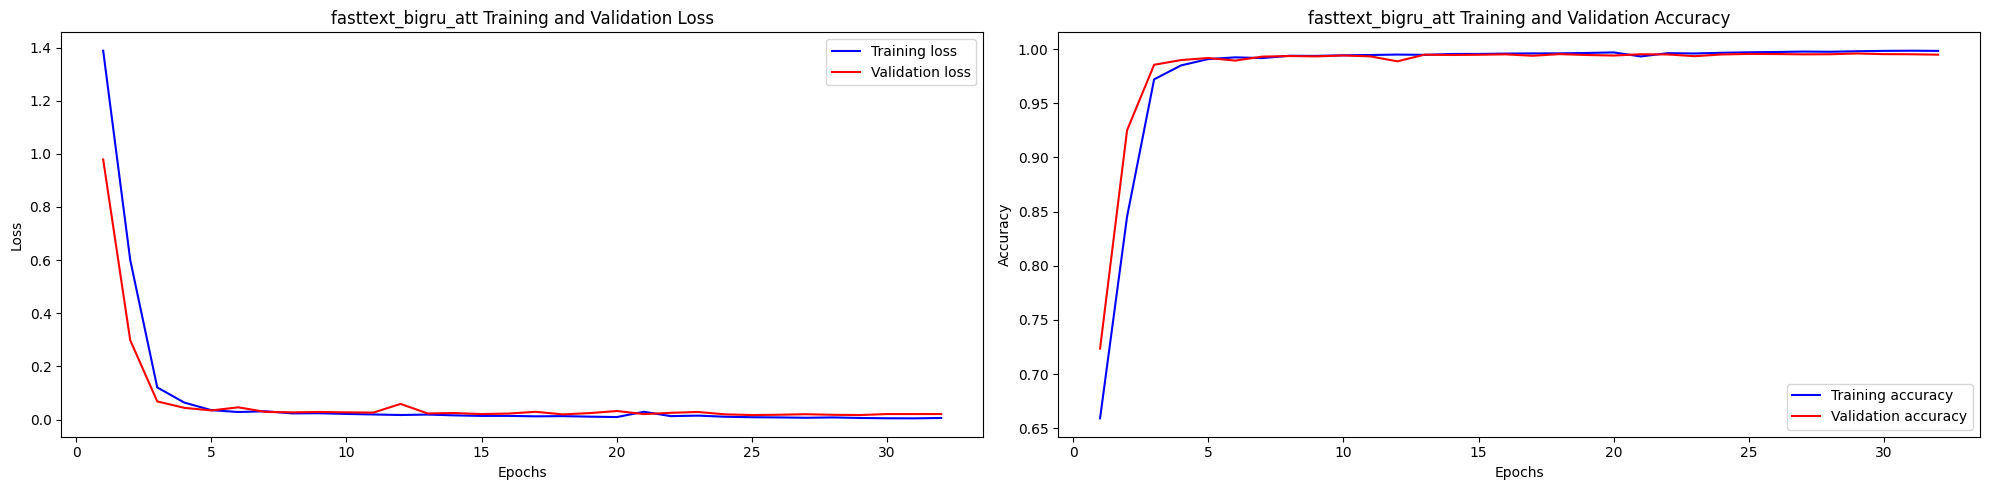

In [39]:
'''
Plot Accuracy and Loss
'''

histories = {
    'bilstm_att': bilstm_att_history,
    'bigru_att': bigru_att_history,
    'fasttext_bilstm_att': fasttext_bilstm_att_history,
    'fasttext_bigru_att': fasttext_bigru_att_history
}

for model_name, history in histories.items():
    plot_loss_accuracy(model_name, history)

In [40]:
'''
Save model
'''

filename = 'fasttext_bilstm_att.pkl'
pickle.dump(fasttext_bilstm_att, open(filename, 'wb'))

filename = 'fasttext_bigru_att.pkl'
pickle.dump(fasttext_bigru_att, open(filename, 'wb'))

filename = 'bilstm_att.pkl'
pickle.dump(bilstm_att, open(filename, 'wb'))

filename = 'bigru_att.pkl'
pickle.dump(bigru_att, open(filename, 'wb'))

In [41]:
def decode_output(decoder_input, tokenizer):
    output_seq = decoder_input[0, 1:-1]
    predicted_text = ""
    for index in output_seq:
        if index == 0:
            continue
        predicted_char = tokenizer.index_word.get(index, '')
        if predicted_char != ' ':
            predicted_text += predicted_char
    return predicted_text

In [42]:
def predict_latin(input_sequences, model, pegon_tokenizer, latin_tokenizer , pegon_max_length, latin_max_length):
    predictions = []
    for input_sequence in input_sequences:
        encoder_input = np.array([input_sequence])
        decoder_input = np.zeros((1, latin_max_length))
        decoder_input[0, 0] = latin_tokenizer.word_index['\t']

        for i in range(1, latin_max_length):
            pred = model.predict([[encoder_input], decoder_input], verbose=0)[0]
            predicted_token_index = np.argmax(pred[i-1])
            decoder_input[0, i] = predicted_token_index
            if predicted_token_index == latin_tokenizer.word_index['\n']:
                break

        predicted_text = decode_output(decoder_input, latin_tokenizer)
        predictions.append(predicted_text)
    return predictions

In [43]:
'''
Predict Data Train
'''

fasttext_bilstm_att_pred = predict_latin(X_val, fasttext_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
fasttext_bigru_att_pred = predict_latin(X_val, fasttext_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bilstm_att_pred = predict_latin(X_val, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_pred = predict_latin(X_val, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis

In [44]:
'''
Get The Latin and Pegon of Data Train
'''

pegon_train, pegon_test, latin_train, latin_test = train_test_split(train_df['pegon'], train_df['latin'], test_size=0.1, random_state=42)

In [45]:
def calculate_cer(row):
    # Calculate Levenshtein distance between Ground Truth and Predicted strings
    distance = levenshtein_distance(row['Ground Truth'], row['Predicted'])

    # Calculate the length of the target (Ground Truth) string
    length = len(row['Ground Truth'])

    # Calculate CER (Character Error Rate) and handle the case when the length is 0
    return distance / length if length > 0 else np.nan

In [46]:
def create_cer_analysis(result_df):
    # Remove '\n' and '\t' from the dataframe
    result_df = result_df.replace(r'\n', '', regex=True).replace(r'\t', '', regex=True)

    # Calculate CER for each row
    result_df['CER'] = result_df.apply(calculate_cer, axis=1)

    # Calculate mean CER
    cer_mean = result_df['CER'].mean()

    # Filter rows with CER > 0
    error_result = result_df[result_df['CER'] > 0]

    return result_df, cer_mean, error_result

## BiLSTM-Att

In [47]:
'''
Calculate CER
'''

bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_pred
})

bilstm_att_result, bilstm_att_cer, bilstm_att_error_result = create_cer_analysis(bilstm_att_result)

print("Average CER: " + str(bilstm_att_cer))

Average CER: 0.013453999626006371


In [48]:
'''
Prediction Result
'''

bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
4423,يَجِدُوْا,yajidu,yajidu,0.000000
4855,وَائَيْ,wae,wae,0.000000
2134,تࣤهَادَيْ,těhade,těhade,0.000000
3742,لَيْسَ,lesa,lesa,0.000000
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125000
...,...,...,...,...
1879,مَرْسࣤفِيْن,marsěfin,marsěpin,0.125000
6424,الْفَاحِشَةَ,al-paẖiśata,al-faẖiśata,0.090909
5442,فِتُودُهْ,pituduh,pituduh,0.000000
4810,وَتَتَّخِذُوْنَ,watattaḵiḋuna,watattaḵiḋuna,0.000000


In [49]:
'''
Error Result
'''

bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125000
16,على,'li,'l,0.333333
1758,٢١,21,2,0.500000
2290,الخَوْفِ,al-ḵaupi,aḵofi,0.625000
1573,فَاكُوْبُوْوَانَا,fakubuana,pakubuana,0.111111
4029,شَرَوْا,śarau,śara,0.200000
6520,أُمَّةْ,ummat,ummah,0.200000
711,چُوْكُوْفَىْ,cukupe,cukufe,0.166667
1555,فِنْتࣤرَىْ,pintěre,fintěre,0.142857
5412,فنجوڠ,pnjuṅ,panjuṅ,0.200000


## BiGRU-Att

In [50]:
bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_pred
})

bigruatt_result, bigru_att_cer, bigru_att_error_result = create_cer_analysis(bigru_att_result)

print("Average CER: " + str(bigru_att_cer))

Average CER: 0.012913281210077163


In [51]:
'''
Prediction Result
'''

bigruatt_result

,Pegon,Ground Truth,Predicted,CER
4423,يَجِدُوْا,yajidu,yajidu,0.000
4855,وَائَيْ,wae,wae,0.000
2134,تࣤهَادَيْ,těhade,těhade,0.000
3742,لَيْسَ,lesa,lesa,0.000
762,فࣤڠْڮَالِيْه,pěṅgalih,pěṅgalih,0.000
...,...,...,...,...
1879,مَرْسࣤفِيْن,marsěfin,marsěpin,0.125
6424,الْفَاحِشَةَ,al-paẖiśata,al-paẖiśata,0.000
5442,فِتُودُهْ,pituduh,pituduh,0.000
4810,وَتَتَّخِذُوْنَ,watattaḵiḋuna,watattaḵiḋuna,0.000


In [52]:
'''
Error Result
'''

bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
16,على,'li,'ll,0.333333
1758,٢١,21,29,0.500000
5519,بَيجَاكࣤنْ,bejakěn,bayjakěn,0.285714
2290,الخَوْفِ,al-ḵaupi,aḵ-ḵofi,0.500000
1573,فَاكُوْبُوْوَانَا,fakubuana,pakubuwana,0.222222
4023,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857
2508,ڠَدَاوُةْ,ṅadawuh,ṅadawut,0.142857
4029,شَرَوْا,śarau,śaro,0.400000
6520,أُمَّةْ,ummat,ummah,0.200000
5845,كَأَنْجࣤنَا,kaanjěna,kaaanjěna,0.125000


## fastText BiLSTM-Att

In [53]:
fasttext_bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bilstm_att_pred
})

fasttext_bilstm_att_result, fasttext_bilstm_att_cer, fasttext_bilstm_att_error_result = create_cer_analysis(fasttext_bilstm_att_result)

print("Average CER: " + str(fasttext_bilstm_att_cer))

Average CER: 0.014252924328809658


In [54]:
'''
Prediction Result
'''

fasttext_bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
4423,يَجِدُوْا,yajidu,yajidu,0.000
4855,وَائَيْ,wae,wae,0.000
2134,تࣤهَادَيْ,těhade,těhade,0.000
3742,لَيْسَ,lesa,lesa,0.000
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125
...,...,...,...,...
1879,مَرْسࣤفِيْن,marsěfin,marsěpin,0.125
6424,الْفَاحِشَةَ,al-paẖiśata,al-paẖiśata,0.000
5442,فِتُودُهْ,pituduh,pituduh,0.000
4810,وَتَتَّخِذُوْنَ,watattaḵiḋuna,watattaḵiḋuna,0.000


In [55]:
'''
Error Result
'''

fasttext_bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125000
16,على,'li,'la,0.333333
5644,فَائَيْهْ,paeh,faeh,0.250000
2290,الخَوْفِ,al-ḵaupi,al-ḵofi,0.375000
1573,فَاكُوْبُوْوَانَا,fakubuana,pakubuana,0.111111
1868,٢٣,23,27,0.500000
4023,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857
1476,فࣤفࣤرَاڠَانْ,pěpěraṅan,fěpěraṅan,0.111111
5835,دَارَارَڠْكَفْ,dararaṅkap,dararaṅkěp,0.100000
4029,شَرَوْا,śarau,śaro,0.400000


## fastText BiGRU-Att

In [56]:
fasttext_bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bigru_att_pred
})

fasttext_bigruatt_result, fasttext_bigru_att_cer, fasttext_bigru_att_error_result = create_cer_analysis(fasttext_bigru_att_result)

print("Average CER: " + str(fasttext_bigru_att_cer))

Average CER: 0.014768555409364854


In [57]:
'''
Prediction Result
'''

fasttext_bigruatt_result

,Pegon,Ground Truth,Predicted,CER
4423,يَجِدُوْا,yajidu,yajidu,0.000
4855,وَائَيْ,wae,wae,0.000
2134,تࣤهَادَيْ,těhade,těhade,0.000
3742,لَيْسَ,lesa,lesa,0.000
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125
...,...,...,...,...
1879,مَرْسࣤفِيْن,marsěfin,marsěpin,0.125
6424,الْفَاحِشَةَ,al-paẖiśata,al-paẖiśata,0.000
5442,فِتُودُهْ,pituduh,pituduh,0.000
4810,وَتَتَّخِذُوْنَ,watattaḵiḋuna,watattaḵiḋuna,0.000


In [58]:
'''
Error Result
'''

fasttext_bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
762,فࣤڠْڮَالِيْه,pěṅgalih,fěṅgalih,0.125000
5116,ڠَاهِيْنَانَا,ṅainana,ṅahinana,0.142857
2290,الخَوْفِ,al-ḵaupi,al-ḵofi,0.375000
1573,فَاكُوْبُوْوَانَا,fakubuana,pakubuana,0.111111
1868,٢٣,23,27,0.500000
2875,تُوْمِنْدَائَا,tumindaa,tumindaaa,0.125000
4023,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857
2508,ڠَدَاوُةْ,ṅadawuh,ṅadawut,0.142857
4029,شَرَوْا,śarau,śaro,0.400000
6520,أُمَّةْ,ummat,ummah,0.200000


## CER Compare

In [59]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'fasttext_bilstm_att', 'fasttext_bigru_att'],
    'CER': [bilstm_att_cer, bigru_att_cer, fasttext_bilstm_att_cer, fasttext_bigru_att_cer]
})

cer_result

,Model,CER
0,bilstm_att,0.013454
1,bigru_att,0.012913
2,fasttext_bilstm_att,0.014253
3,fasttext_bigru_att,0.014769


# Model Testing

In [60]:
best_model = bigru_att

In [61]:
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(test_df['pegon'], pegon_tokenizer)

In [62]:
pred = predict_latin(padded_pegon, best_model, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

In [63]:
result = pd.DataFrame({
    'Pegon': test_df['pegon'],
    'Ground Truth': test_df['latin'],
    'Predicted': pred
})

model_result, model_cer, model_error_result = create_cer_analysis(result)

print("Average CER: " + str(model_cer))

Average CER: 0.013357844313838243


In [64]:
model_result

,Pegon,Ground Truth,Predicted,CER
1181,فَاڠَيْستُوْنِيْفُوْن,paṅestunipun,naṅestunipunipue,0.416667
5050,تَرَارُوْبَةْ,tararubat,tararubat,0.000000
4053,وَاتَّقُوْهُ,wattaquhu,wattaquhu,0.000000
3751,كَاكُوَاسَأَنْ,kakuasaan,kakuasaan,0.000000
6490,ڠَرَوْڮَهَلَا,ṅarogahala,ṅaraugahala,0.200000
...,...,...,...,...
2317,خِلَافْ,ḵilap,ḵilap,0.000000
291,فࣤنْدِيْطَا,pěndiṯa,pěndiṯa,0.000000
6076,دَاڮِڠْنَا,dagiṅna,dagiṅna,0.000000
842,بَارࣤڠْ,barěṅ,barěṅ,0.000000


In [65]:
model_error_result.shape

(44, 4)

In [66]:
model_error_result

,Pegon,Ground Truth,Predicted,CER
1181,فَاڠَيْستُوْنِيْفُوْن,paṅestunipun,naṅestunipunipue,0.416667
6490,ڠَرَوْڮَهَلَا,ṅarogahala,ṅaraugahala,0.200000
3123,مࣤمْفࣤڠْ,měmfěṅ,měmpěṅ,0.166667
96,وَغَيْرُهُ,waġairuhu,waġeruhu,0.222222
3404,وَالْأَرْضِ,wal-arḏi,wal-alarḏi,0.250000
4450,بَيْتِيَ,betiya,betia,0.166667
1410,كࣤلَواَنْ,kěloan,kělawan,0.333333
3349,ڠَوُلَڠْكࣤنْ,ṅawulaṅkěn,ṅaulaṅkěn,0.100000
1511,فَتْحُ,fatẖu,patẖu,0.200000
3481,فَاسْتَوْصُوْا,pastauṣu,pastoṣu,0.250000
